In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from skimage import io
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/Post-hurricane.zip -d hurricane_data

Streaming output truncated to the last 5000 lines.
  inflating: hurricane_data/train_another/no_damage/-95.62751800000001_29.857785999999997.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.62751999999999_29.860796999999998.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627523_29.770004999999998.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.62753000000001_29.863289.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627539_29.827047999999998.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627543_29.860021000000003.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627563_29.8628.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627579_29.864051.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.627595_29.776602.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.62759799999999_29.777317.jpeg  
  inflating: hurricane_data/train_another/no_damage/-95.62760300000001_29.

In [4]:
DIR = '/content/hurricane_data'
train_path = os.path.join(DIR, 'train_another')
val_path = os.path.join(DIR, 'validation_another')
test_path = os.path.join(DIR, 'test')

In [5]:
# load test data
image_size = (128, 128)
batch_size = 32

# specify test image transformations (rescale only)
test_datagen = ImageDataGenerator(rescale=1./255)

# test images, with shuffle
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

#test images, no shuffle (so results can be matched to image filenames)
test_generator_noshuff = test_datagen.flow_from_directory(
        test_path,
        target_size=image_size,
        batch_size=batch_size,
        shuffle=False,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
# load best performing model
best_model = load_model('/content/drive/MyDrive/TL/best_model.h5')

In [8]:
eval_results = best_model.evaluate(x=test_generator, verbose=1)

63/63 [==============================] - 145s 2s/step - loss: 0.1242 - accuracy: 0.9570


In [9]:
def find_missclassed_images(model):

    '''Given a model, returns dataframe of missclassified images and confusion matrix'''

    # get true labels, predictions
    true_labels = test_generator_noshuff.classes
    predictions = best_model.predict(test_generator_noshuff, verbose=1)

    #switching labels to be more intuitive
    y_true = np.array([1 if x==0 else 0 for x in true_labels])
    pred_interim = [np.argmax(x) for x in predictions]
    y_pred = np.array([1 if x==0 else 0 for x in pred_interim])

    #y_true = true_labels
    #y_pred = np.array([np.argmax(x) for x in predictions])

    #get filenames, create dataframe from dict
    filenames = test_generator_noshuff.filenames
    df_dict = {'filenames':filenames,'true_label':y_true,'pred_label':y_pred}
    df = pd.DataFrame(df_dict)
    misslabelled = df[df['true_label'] != df['pred_label']]

    return misslabelled, y_true, y_pred

In [10]:
missclass_df, true, pred = find_missclassed_images(best_model)

63/63 [==============================] - 158s 2s/step


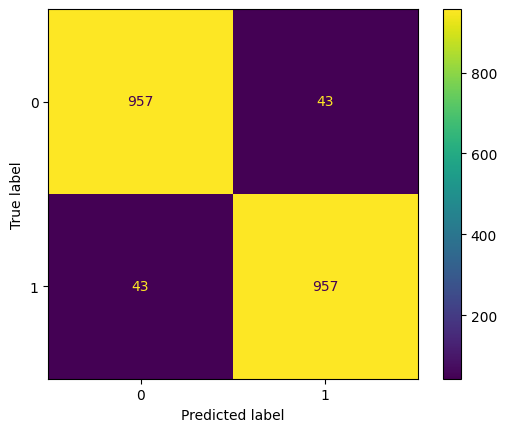

In [11]:
#confusion matrix
ConfusionMatrixDisplay.from_predictions(true, pred);

In [12]:
#get confusion matrix valuues and calculate FP, FN, TN, TP:
cm = confusion_matrix(true, pred)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [13]:
# Sensitivity, hit rate, recall, or true positive rate for the positive class (which is actually 0 here)
TPR = TP/(TP+FN)
print(f'Sensitivity/TPR: {TPR[0]}')
# Specificity or true negative rate
TNR = TN/(TN+FP)
print(f'Specificity/TNR: {TNR[0]}')
# Precision or positive predictive value
PPV = TP/(TP+FP)
print(f'Precision: {round(PPV[0],3)}')
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(f'Fallout/FPR: {FPR[0]}')
# False negative rate
FNR = FN/(TP+FN)
print(f'FNR: {FNR[0]}')

Sensitivity/TPR: 0.957
Specificity/TNR: 0.957
Precision: 0.957
Fallout/FPR: 0.043
FNR: 0.043


In [14]:
# false positive (ie pred=damage(1), true=no damage(0))
fp_list = list(missclass_df[missclass_df.pred_label==1].filenames)

# false negative (ie pred=no damage (0), true=damage(1))
fn_list = list(missclass_df[missclass_df.pred_label==0].filenames)

In [15]:
def create_image_list(filename_list):
    images_list = []
    for filename in filename_list:
        #load  image
        tile_path = os.path.join(DIR, 'test', filename)
        tile = io.imread(tile_path)
        #add image array to list
        images_list.append(tile)

    return images_list

In [16]:
# generate lists of FN/FN image arrays
fp_img_list = create_image_list(fp_list)
fn_img_list = create_image_list(fn_list)

In [17]:
def plot_img_matrix(images_list, rows, columns):

    '''Given a list of image arrays, plot them as tiles in a single figure'''
    f, axarr = plt.subplots(rows,columns, figsize=(columns*2,rows*2))
    img_idx = 0

    for row_idx in range(rows):
        for col_idx in range(columns):

            axarr[row_idx,col_idx].imshow(images_list[img_idx])
            axarr[row_idx,col_idx].axis('off')
            img_idx +=1

    plt.show()

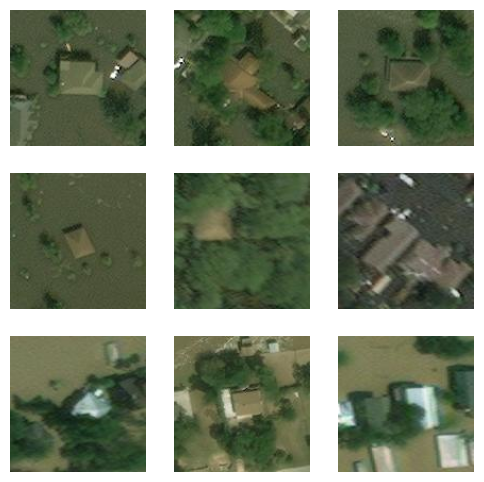

In [28]:
# plot false negative images (where there was damage but none was detected)
plot_img_matrix(fn_img_list, 3, 3)

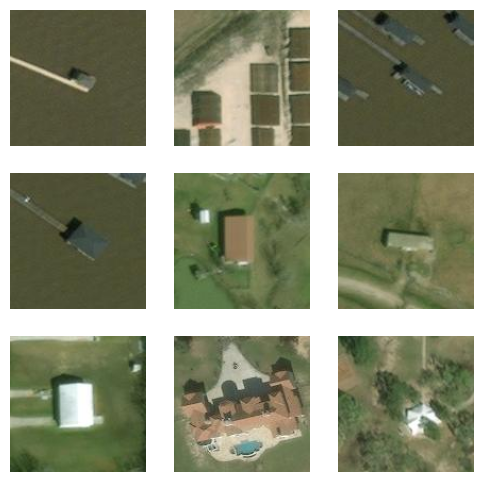

In [29]:
# plot false positive images (no damage but detected as damage)
plot_img_matrix(fp_img_list, 3, 3)

Correctly classified

In [30]:
def find_correct_images(model):

    '''Given a model, returns dataframe of correct images and confusion matrix'''

    # get true labels, predictions
    true_labels = test_generator_noshuff.classes
    predictions = best_model.predict(test_generator_noshuff, verbose=1)

    #switching labels to be more intuitive
    y_true = np.array([1 if x==0 else 0 for x in true_labels])
    pred_interim = [np.argmax(x) for x in predictions]
    y_pred = np.array([1 if x==0 else 0 for x in pred_interim])

    #y_true = true_labels
    #y_pred = np.array([np.argmax(x) for x in predictions])

    #get filenames, create dataframe from dict
    filenames = test_generator_noshuff.filenames
    df_dict = {'filenames':filenames,'true_label':y_true,'pred_label':y_pred}
    df = pd.DataFrame(df_dict)
    correct = df[df['true_label'] == df['pred_label']]

    return correct, y_true, y_pred

In [31]:
correct_df, a, b = find_correct_images(best_model)

63/63 [==============================] - 147s 2s/step


In [32]:
# true positive (ie pred=damage(1), true=no damage(1))
tp_list = list(correct_df[correct_df.true_label==1].filenames)
tp_img_list = create_image_list(tp_list)
# shuffle so images plotted are random
random.shuffle(tp_img_list)

# true negative (ie pred=no damage (0), true=damage(0))
tn_list = list(correct_df[correct_df.true_label==0].filenames)
tn_img_list = create_image_list(tn_list)
random.shuffle(tn_img_list)

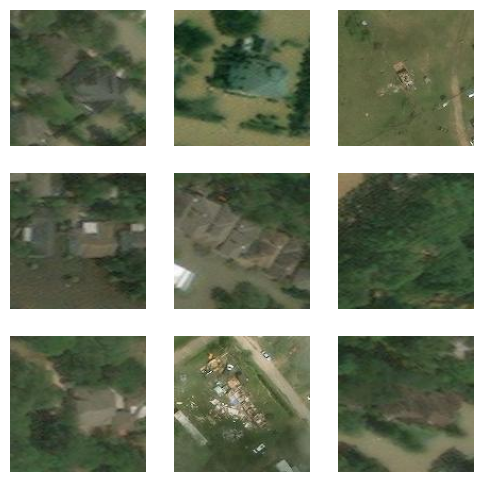

In [33]:
# true positive examples
plot_img_matrix(tp_img_list, 3, 3)

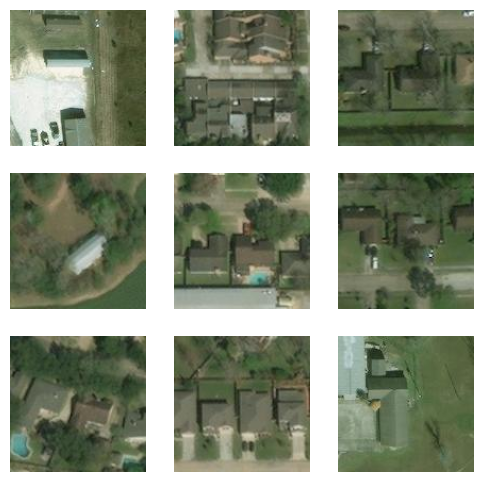

In [34]:
# true negative examples
plot_img_matrix(tn_img_list, 3, 3)

In [35]:
best_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 64, 64, 32)           2432      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)           0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 16, 16, 64)           18496     ['max_pooling2d_3[0][0]'